<a href="https://colab.research.google.com/github/samvardhan/stan_workshop/blob/main/stan_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.8 MB/s eta 0:00:00


In [2]:
# this is needed to enable running stan (there is a bug )
!pip install nest_asyncio

In [3]:
import stan
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import nest_asyncio
nest_asyncio.apply()

# **LINEAR REGRESSION**!

---
## General Formula
##  Y = alpha + beta * X + e
### e ~ N(0,sigma)

---





Generate Data

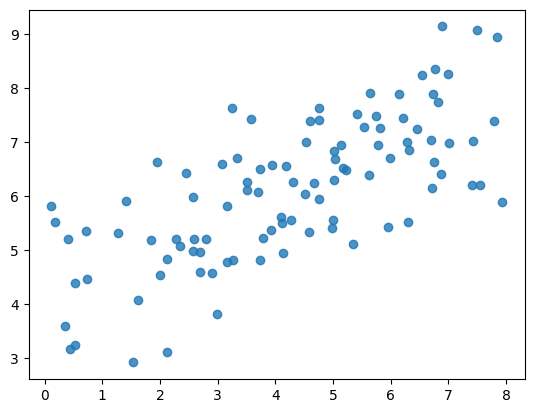

In [4]:
# Parameters to be inferred

alpha = 4.0  #intercept
beta = 0.5 #slopes
sigma = 1.0 #error

# Generate data
x =  8 * np.random.rand(100)

y = alpha + beta * x
y = np.random.normal(y, scale=sigma) #noise

#visualize generated data
plt.scatter(x, y, alpha = 0.8)

Build STAN model block

In [5]:
model = """
data {                    //input the data to STAN
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {              //define parameters for the model
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {                   //define the model structure, and priors

    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1);   //why?

    //model
    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {    //get quantities of interest from fitted model
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);             //generate samples from model
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma); //probability of data given the model and parameters
        }
}
"""

Model Parameters

In [6]:
#STAN takes data as a dict
data = {'N': len(x), 'x': x, 'y': y}

#parameters for STAN fitting
chains = 2
samples = 1000
warmup = 10
# set seed


# Compile the model
posterior = stan.build(model, data=data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)


Building...



Building: 57.7s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  50% (2000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!


In [7]:
# Extracting traces

alpha = fit['alpha'].reshape(chains,samples) #arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


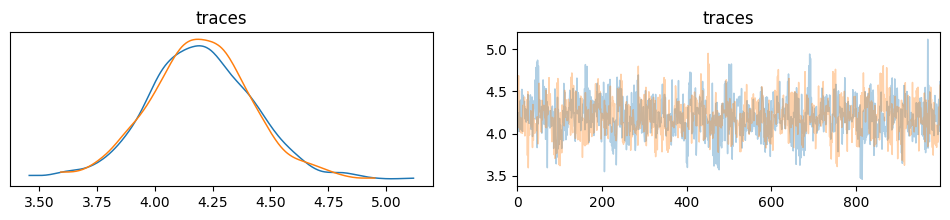

In [8]:
varname = alpha
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('traces')

<Axes: title={'center': 'x'}>

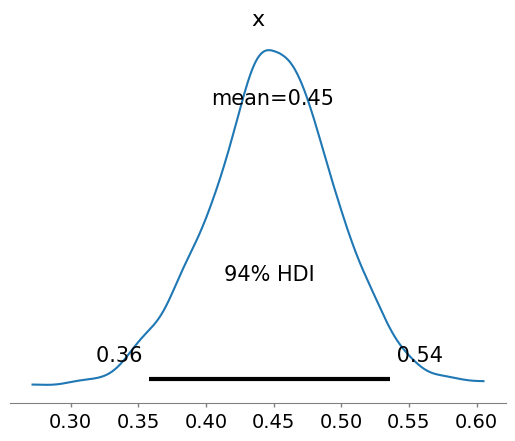

In [9]:
az.plot_posterior(beta)

## EXERCISE: Re-Run Linear Regression: 'Try to fail'

Try to make the model convergence fail. To achieve this, you can either-

- Reduce number of iterations *N*
- Use strongly informative but wrong priors for *alpha* or *beta*:

alpha ~ uniform(0,3);
beta ~ uniform(1,2);


Try to identify why convergence failed? Either
- the model chains did not have enough samples to converge
- the model doesn't explore the highest density area






# 2: Group Level Effect

---
## General Formula
##  Y = alpha[group] + beta * X + e
### e ~ N(0,sigma)

Group?
- Students in schools
- Clients nested within therapists within clinics
- Employees nested within organizations
- Citizens nested within employees
- Repeated measures nested within persons
---

Generate Data

In [10]:
# Parameters to be inferred
alpha = [0,6.0,9.0, 7.0]

beta = 0.5

sigma = 1

# Generate and plot data
x1 = 10 * np.random.rand(100)

y1 =  np.random.normal(alpha[1] + beta * x1, scale= sigma)
y2 =  np.random.normal(alpha[2] + beta * x1, scale= sigma)
y3 = np.random.normal(alpha[3] + beta * x1, scale= sigma)

# made up  dataset
df = pd.DataFrame()
df['x'] = np.concatenate((x1, x1, x1))
df['y'] = np.concatenate((y1, y2, y3))
df['group'] = np.concatenate((np.repeat(1, len(y1)),np.repeat(2, len(y2)),np.repeat(3, len(y3))))
df

,x,y,group
0,9.531914,10.321100,1
1,6.483252,11.032622,1
2,1.499535,5.934505,1
3,2.490309,6.671593,1
4,9.895078,12.428791,1
...,...,...,...
295,2.214203,7.446738,3
296,2.978753,7.336957,3
297,8.376306,10.670425,3
298,5.962959,9.553766,3


Text(0.5, 1.0, 'Generated data with group-level intercept')

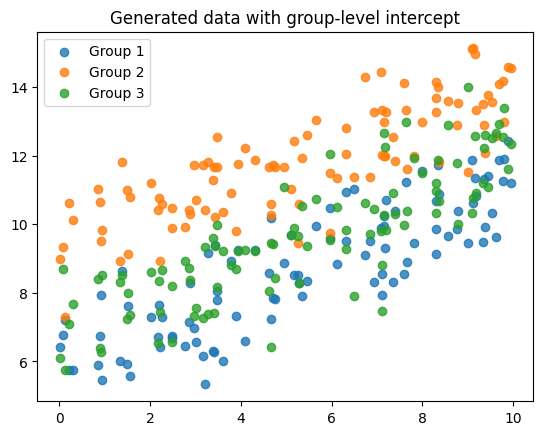

In [11]:
#visualize generated data
plt.scatter(x1, y1, label = 'Group 1', alpha = 0.8)
plt.scatter(x1, y2, label = 'Group 2', alpha = 0.8)
plt.scatter(x1, y3, label = 'Group 3', alpha = 0.8)
plt.legend()
plt.title('Generated data with group-level intercept')

STAN Model Block

In [14]:
group_level_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;

    int<lower=0> J;         //number of groups
    array[N] int group;;    //lookup list for each data point's group ID

}

parameters {
    vector[J] alpha;
    real beta;
    real<lower=0> sigma;
}


transformed parameters { //combining parameters to make intermediate parameters
    vector[N] mu;

    for (n in 1:N){
        mu[n] = alpha[group[n]];
        mu[n] = mu[n] + beta * x[n];
    }

}


model {
    //EXERCISE 2
    beta ~ normal(0,10);

    for (j in 1:J){
      alpha[j] ~ normal(0,10);
      }



    for (n in 1:N){
        y[n] ~ normal(mu[n], sigma);
    }
}

generated quantities{
    vector[N] log_lik;
    vector[N] yhat;
    for (n in 1:N){
        log_lik[n] = normal_lpdf( y[n] | mu[n], sigma);
        yhat[n] = normal_rng( mu[n], sigma);
        }
}

"""

In [15]:
group_level_data = {'N': len(df.x), 'x': df.x.values, 'y': df.y.values,
        'group':df.group.values,'J':df.group.nunique()}
#Note: STAN starts counting at 1

chains = 2
samples = 1000
warmup = 100

# Compile the model
posterior = stan.build(group_level_model, data=group_level_data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)


Building...



Building: 39.4s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   3% (101/4000)
Sampling:   5% (201/4000)
Sampling:   8% (300/4000)
Sampling:  15% (600/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  28% (1100/4000)
Sampling:  32% (1300/4000)
Sampling:  38% (1500/4000)
Sampling:  40% (1600/4000)
Sampling:  72% (2900/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000177 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.77 seconds.
  Adjust your expectations accordingly!


In [16]:
# Extracting traces
alpha = [fit['alpha'][i].reshape(chains,samples) for i in range(3)]#arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)

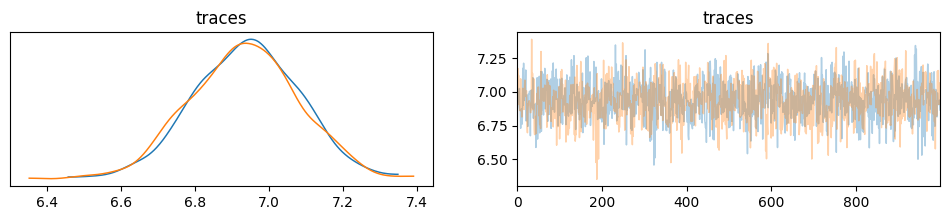

In [17]:
varname = alpha[2]
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('traces')

## **Compare Models**
Next, we run the group-level model and the simple model results for the group-level dataset, and compare the results. Common sense would indicate that the group-level model is a better descriptor of our constructed group-level data. What is a metric that can quantify this?
### Watanabe–Akaike information criterion

https://en.wikipedia.org/wiki/Bayesian_information_criterion


In [25]:
def compute_waic(fit):
    log_lik  = fit['log_lik']
    scale_value=1
    shape         = log_lik.shape
    n_samples     = shape[0]
    n_data_points = shape[1]
    vars_lpd      = np.var(log_lik,axis=0)
    lppd_i        = np.log(np.mean(np.exp(log_lik),axis=0))


    waic_i        = scale_value * (lppd_i - vars_lpd)
    waic_se       = (n_data_points * np.var(waic_i)) ** 0.5
    waic_sum      = np.sum(waic_i)
    p_waic        = np.sum(vars_lpd)
    return [waic_sum,waic_se]



# rewrite simple model

In [20]:
simple_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1); //why?

    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma);
        }
}
"""

# Run both the Simple model and Group level model on group level data

In [23]:
#Group-level Model
posterior_group = stan.build(group_level_model, data=group_level_data, random_seed = 42)
fit_group = posterior_group.sample(num_chains=chains, num_samples=samples )

#Ignoring Group-level effect
posterior = stan.build(simple_model, data=group_level_data,random_seed = 42)
fit = posterior.sample(num_chains=chains, num_samples=samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000177 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.77 seconds.
  Adjust your expectations accordingly!


Building...



Building: 36.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (100/4000)
Sampling:   5% (200/4000)
Sampling:   8% (300/4000)
Sampling:  10% (400/4000)
Sampling:  15% (600/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  28% (1100/4000)
Sampling:  35% (1400/4000)
Sampling:  42% (1700/4000)
Sampling:  72% (2900/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!


In [24]:
waic_group = compute_waic(fit_group)
waic = compute_waic(fit)

print(waic_group, waic)

[-3442.7335578637276, 2.538567022000564, 883.5850039271386] [-4206.950794520205, 1.5357323869095527, 610.3816944649483]


TAKE HOME EXERCISE


---


Similar to intercept alpha, add Group-Level Effect for slope Beta.